In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Read Documents

Simple Wiki's abstracts

In [5]:
all_docs = !xmllint --shell /Users/jencirlee/Workbench/data/simplewiki-latest-abstract.xml.gz <<< "cat //doc/abstract"

In [6]:
all_docs = all_docs[1::2]
len(all_docs)

130870

In [71]:
docs = [s for s in all_docs
        if 'United States' in s]
len(docs)

6130

# Topic Modelling

In [9]:
n_features = 20000
n_components = 10

In [10]:
def print_top_words_factors(factors, feature_names, n_top_words):
    ''' Print top words of each topic '''
    for topic_idx, topic in enumerate(factors):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def print_top_words(model, feature_names, n_top_words):
    ''' Print top words of each topic '''
    print_top_words_factors(model.components_, feature_names, n_top_words)

## NMF

In [67]:
tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=1,
                                   max_features=n_features,
                                   lowercase=False,
                                   stop_words='english')
tfidf_vectorizer.fit(all_docs)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [72]:
tfidf = tfidf_vectorizer.transform(docs)
tfidf.shape

(6130, 20000)

In [73]:
nmf = NMF(n_components=20, init='random', alpha=.3, l1_ratio=1e-6)
nmf.fit(tfidf)

NMF(alpha=0.3, beta_loss='frobenius', init='random', l1_ratio=1e-06,
  max_iter=200, n_components=20, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [74]:
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: United States country Canada It Army Court Washington American Navy Census Supreme Kingdom In town counties people Senator government thumb
Topic #1: Indiana state States United city Warsaw Bloomington Delaware Indianapolis Gary Vernon Lafayette Greenfield Brazil Auburn Frankfort Aurora Dunkirk Huntington Delphi
Topic #2: Idaho States United city Falls Springs Lake Twin Ferry Hope River Teton Lava St Clayton Dover Cascade Irwin Ashton Georgetown
Topic #3: Arkansas America state States United city Springs County Sebastian Rock living Bluff Little Camden North Mountain Delaware Clarksville located Fulton
Topic #4: Chicago skyscraper floors meters tall feet It United States Building Tower Center Plaza Side Park birth_place community suburb largest Loop
Topic #5: Virginia town States United Norfolk Mount Clifton Hampton Gap Gate West Creek Royal Charles Nelson McClure About Hill Alexandria Mill
Topic #6: census population County 2010 2000 Alabama At The As people town States Unit

(array([ 23., 131., 131.,  91.,  74.,  62.,  47.,  36.,  17.,   4.]),
 array([0.00827517, 0.06509457, 0.12191398, 0.17873338, 0.23555279,
        0.29237219, 0.3491916 , 0.406011  , 0.46283041, 0.51964981,
        0.57646922]),
 <a list of 10 Patch objects>)

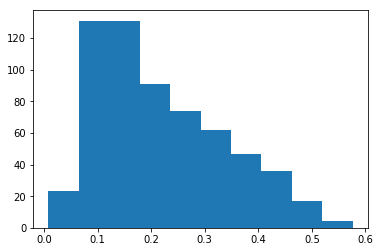

In [60]:
plt.hist(nmf.transform(tfidf).max(axis=1))

In [61]:
__topic_nmf = nmf.transform(tfidf)[:, 6] > .3
__topic_nmf.sum()

5

In [62]:
np.array(docs)[__topic_nmf]

array(["<abstract>The Yangtze River, or Yangzi (Simple Chinese: 扬子江 / Traditional Chinese: 揚子江), or Chang Jiang (Simple Chinese: 长江 / Traditional Chinese: 長江), is the longest River in China and Asia, as well as the world's third longest river (after the Amazon and the Nile). It is honored as one of the two main cradles of Chinese civilization.</abstract>",
       '<abstract>The Hanyu Shuiping Kaoshi, (simplified Chinese: 汉语水平考试; traditional Chinese: 漢語水平考試; hanyu pinyin: Hànyǔ Shuǐpíng Kǎoshì), shortened as HSK, is the People\'s Republic of China\'s only standardized test of Standard Mandarin Chinese proficiency for non-native speakers, such as foreign students, overseas Chinese, and members of ethnic minority groups in China. It is also known as the "Chinese Proficiency Test".</abstract>',
       "<abstract>The CCTV New Year's Gala (Simplified Chinese: 中国中央电视台春节联欢晚会; Traditional Chinese: 中國中央電視台春節聯歡晚會; Pinyin: Zhōngguó zhōngyāng diànshìtái chūnjié liánhuān wǎnhuì) is a Chinese New Yea

## Latent Dirichlet Allocation

Variational Inference for LDA

In [11]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,
                                max_features=n_features,
                                lowercase=False,
                                stop_words='english')
tf_vectorizer.fit(all_docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
tf = tf_vectorizer.transform(docs)
tf.shape

(6130, 20000)

In [13]:
lda = LatentDirichletAllocation(n_components=20,
                                doc_topic_prior=1,
                                topic_word_prior=.1,
                                max_iter=10,
                                learning_method='online',
                                learning_offset=1000)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=1,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=1000,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=0.1,
             total_samples=1000000.0, verbose=0)

In [14]:
print_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: United States city Iowa state Illinois Arkansas birth_place Kentucky America Idaho Florida Virginia It California Texas Indiana Houston The Oklahoma
Topic #1: States United city birth_place Iowa Kentucky town Virginia Illinois state Arkansas City America New Oklahoma Louis Florida It Idaho Indiana
Topic #2: States United city birth_place Iowa town Florida state Illinois America The Virginia It Idaho County New Kentucky California Arkansas Oklahoma
Topic #3: States United city birth_place Kentucky Iowa Illinois New town state Virginia York County America Florida California It The City Louisiana
Topic #4: States United city Iowa birth_place Illinois Idaho Kentucky state Florida New County California America Oklahoma It town Virginia Texas The
Topic #5: States United city Iowa birth_place town City state Virginia Kentucky New Illinois America California Idaho York Arkansas Florida Indiana County
Topic #6: States United city Iowa birth_place Kentucky Illinois Virginia state town 

(array([1.000e+00, 2.300e+01, 2.000e+00, 5.200e+01, 1.959e+03, 9.940e+02,
        6.330e+02, 1.027e+03, 1.157e+03, 2.820e+02]),
 array([0.23998861, 0.30997159, 0.37995458, 0.44993757, 0.51992055,
        0.58990354, 0.65988653, 0.72986952, 0.7998525 , 0.86983549,
        0.93981848]),
 <a list of 10 Patch objects>)

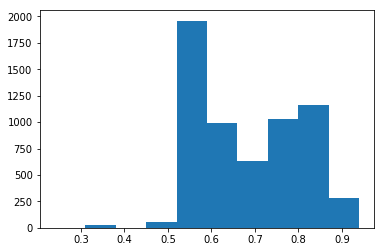

In [74]:
plt.hist(lda.transform(tf).max(axis=1))

In [77]:
__topic_lda = lda.transform(tf)[:, 3] > .1
__topic_lda.sum()

0

## Spectral LDA

In [15]:
import sys
sys.path.insert(0, '../SpectralLDA')

from spectral_lda import spectral_lda

Using mxnet backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using numpy backend.


In [31]:
alpha, beta = spectral_lda(tf, 20, 20, eps=1.0)

# docs: 6130	# valid: 6106


RuntimeError: Invalid results from CPDecomp.

In [73]:
alpha, alpha.sum()

(array([0.05925362, 0.18486831, 0.77896131, 0.14335609, 1.14590444,
        0.08582096, 0.49797297, 0.37264371, 0.37460232, 0.1789797 ,
        0.17568921, 0.02837142, 0.14877573, 0.12546624, 0.09682436,
        0.05977945, 0.17551349, 0.00987483, 0.00896048, 0.0025466 ]),
 4.654165257546078)

In [61]:
print(beta.T[0].max())

0.15638433987404624


In [62]:
print_top_words_factors(beta.T, tf_vectorizer.get_feature_names(), 20)

Topic #0: China province Republic The It capital People city Province Zhejiang County Henan east southeast Shandong Jiangxi called Municipality coast largest
Topic #1: China birth_place Shanghai Beijing death_place Liaoning District Origin Republic Anhui Guangzhou Hunan Tianjin Settlement Hainan Jilin Guangdong Jiangxi International train
Topic #2: Republic Shanghai Chinese Anhui It thumb Liaoning known Japan residence species list Jilin Xi Sea Korea born southeast Li Jiangsu
Topic #3: city county national district University team football born birth_place Dynasty Shanghai Chinese dynasty National situated Nanjing Kong He Hong tall
Topic #4: China Beijing death_place University university Origin Normal normal Hebei prestigious It universities Nanjing 1898 museum prefecture created Summer symbol oldest
Topic #5: Beijing It Chinese birth_place India Wuhan He Hebei Nanjing birthplace National Japan city mountain Dynasty Communist province dynasty Party BC
Topic #6: China dynasty The This 